# Creating A 1-Layer Neural Network (Perceptron/Logistic Regression) from Scratch

Using it to binary classify bag vs not bag

In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [3]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784)
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784)
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")

In [4]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 784)
(12000,)
(1000, 784)
(1000,)


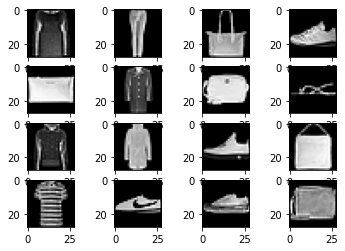

In [5]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))].reshape(28, 28))

In [6]:
def sigmoid(z):
    """Compute the logistic function"""
    return 1. / (1. + np.exp(-z))
def sigmoid_d(z):
    """Compute derivative of the logistic function"""
    fz = sigmoid(z)
    return fz * (1 - fz)
def loss(y_hat, y):
    """Single sample MSE loss"""
    return ((y - y_hat) ** 2) / 2

In [7]:
def forward(x, params):
    """Compute forward pass"""
#     x = x.reshape(28**2, 1) # Place sample into single vector
    forward_res = {}
    forward_res["z"] = params["w"] @ x + params["b"]
    forward_res["a"] = sigmoid(forward_res["z"])
    
    return forward_res

def backprop(x, y, params):
    """Compute gradients analytically"""
#     x = x.reshape(28**2, 1)
    # Forward Pass
    fwd_pass = forward(x, params)
    
    # Backwards Pass
    dL_dz = (fwd_pass["a"] - y) * sigmoid_d(fwd_pass["z"])
    
    grad = {}
    grad["w"] = dL_dz * x
    grad["b"] = dL_dz

    return grad

In [8]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(x, params)
    return forward_res["a"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

In [9]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        l += loss(yhat, ys[i])
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData

# Gradient Checking

In [10]:
def init_empty_params(m):
    """Return a copy of model parameters filled with zeros"""
    grad = {}
    for k in m:
        grad[k] = np.zeros_like(m[k])
    return grad

def flatten(m):
    """Compress model parameters into a 1D array"""
    model_params = [m[k] for k in sorted(m)]
    vec = np.zeros(sum([x.size for x in model_params]))
    offset = 0
    for param in model_params:
        vec[offset:offset + param.size] = param.reshape(param.size)
        offset += param.size
    return vec

def unflatten(m, vec):
    """Uncompress 1D array of model parameters into dictionary"""
    blank_params = [m[k] for k in sorted(m)]
    offset = 0
    for param in blank_params:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m

In [11]:
def run_fd(x, y, m):
    """Return the finite difference estimation of the gradients"""
    eps = 1e-8 # epsilon
    vecm = flatten(m) # Compress params into 1D vector
    gradm = init_empty_params(m)
    vecgradm = flatten(gradm) # Create compressed gradient results vector
    for i in range(vecm.size):
        wi = vecm[i] # Cache real value
        vecm[i] += eps / 2 # Add epsilon/2 to an individual weight
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        u = loss(yhat, y) # Get loss of data/params with epsilon update
        vecm[i] = wi # Reset to real value
        vecm[i] -= eps / 2
        yhat = predict_raw(x, unflatten(init_empty_params(m), vecm))
        l = loss(yhat, y) # Get other side
        vecgradm[i] = (u - l) / eps # Assign result to grad vector
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm) # Return dict form of grad

def compare_gradients(xs, ys, i):
    x, y = xs[i], ys[i]
    img_size = 784
    # Initialise a random set of parameters
    params = {"w": np.random.randn(img_size) / 100,
              "b": np.random.randn(1)}
    bp_an = backprop(x, y, params) # Compute analytical gradients
    bp_fd = run_fd(x, y, params) # Compute finite differences gradients
    for grad_key in bp_an:
        # Compare each gradient from analytical to f.d. estimation
        print(np.allclose(bp_an[grad_key], bp_fd[grad_key]))
compare_gradients(trainxs, trainys, 5678)
compare_gradients(trainxs, trainys, 8765)

True
True
True
True


# Building the Training Algorithm

In [12]:
def train_logistic_regression(
    xs, ys, devxs, devys, 
    n_epochs=3, learning_rate=0.1, 
    momentum=0, batch_size=0
):
    """Initialize and train Logistic Regression on a dataset, 
    generating performance metrics at each epoch
    Returns: (epochs, t_losses, t_accs, v_losses, v_accs, params)
    """
    # Initialize Hyperparameters
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]
    
    lr = learning_rate
    a = momentum # alpha
    
    # batch_size of 0 is full batch (batch_size 1 is s.g.d.)
    if batch_size == 0:
        batch_size = nData
    
    # Show model hyperparameters for debugging
    print("nData:", nData, 
          "Learning Rate:", lr, 
          "Momentum:", momentum, "Batch Size:", batch_size)
    
    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []
    
    # Initialize model parameters
    params = {"w": np.zeros(img_size),
              "b": np.zeros(1)}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    v = {}
    for theta in params:
        v[theta] = np.zeros_like(params[theta])
    
    # Start training process
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        t_loss, t_acc = nvalidate(xs, ys, params)
        t_accs.append(t_acc)
        t_losses.append(t_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)

        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            for theta in params:
                grad[theta] = np.zeros_like(params[theta])
            
            for i in batch:
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                
                # Update batch gradient with incremental gradient
                for theta in grad_i:
                    grad[theta] += grad_i[theta] / batch_size
            
            # Perform exponentially averaged momentum update
            for theta in v:
                v[theta] = a * v[theta] + (1-a) * grad[theta]
            
            # Perform model parameter update
            for theta in params:
                params[theta] -= lr * v[theta]
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [13]:
_ = train_logistic_regression(
        trainxs, trainys,
        devxs, devys,
        n_epochs=5,
        learning_rate=0.1,
        momentum=0.4,
        batch_size=8,
    )

nData: 12000 Learning Rate: 0.1 Momentum: 0.4 Batch Size: 8
----------------------------------
Epoch: 0
Val Acc: 0.505 Val Loss: 0.8181471805599257
----------------------------------
Epoch: 1
Val Acc: 0.966 Val Loss: 0.15008893390164338
----------------------------------
Epoch: 2
Val Acc: 0.972 Val Loss: 0.12681432650842037
----------------------------------
Epoch: 3
Val Acc: 0.971 Val Loss: 0.11637520592318817
----------------------------------
Epoch: 4
Val Acc: 0.973 Val Loss: 0.10917254185238173


In [14]:
def grid_search(mts, lrs, bzs, hzs, epchns):
    # Recall previous results from file
    gridsearch = {}
    try:
        with open("gridsearch.p", "rb") as fp:
            gridsearch = pickle.load(fp)
    except:
        print("No pickle file found, continuing...")
    for hz in hzs:
        for mt in mts:
            for lr in lrs:
                for bz in bzs:
                    for epchn in epchns:
                        key = "hids{}_momt{}_lr{}_bchsz{}_epch{}"\
                            .format(hz, mt, lr, bz, n_epochs)
                        print("Running", key)
                        if key in gridsearch.keys():
                            print("Skipping", key)
                            continue
                        gridsearch[key] = train_two_layer_perceptron(
                        trainxs, trainys,
                        devxs, devys,
                        n_epochs=epchn,
                        learning_rate=lr,
                        momentum=mt,
                        batch_size=bz,
                        )
                        with open("gridsearch.p", "wb") as fp:
                            pickle.dump(gridsearch, fp,
                            protocol=pickle.HIGHEST_PROTOCOL)
momentums = [0, 0.2, 0.4]
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [1, 8, 1000, 12000]
epoch_ns = [50, 100, 300]
grid_search(momentums, learning_rates, batch_sizes, epoch_ns)